# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import importlib
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display
from skimage.measure import find_contours
from skimage.measure import moments
from skimage.draw import circle
#import cv2
#import imutils

# Root directory of the project
#ROOT_DIR = os.path.abspath("/home/akshay/Mask_RCNN/")
ROOT_DIR = os.path.abspath("../")
print (ROOT_DIR)
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
#from mrcnn import visualize

#from mrcnn import vis

#importlib.reload(visualize)

#importlib.reload(vis)
#from ipynb.fs.full.mrcnn.vis import * as vis
# Import COCO config
print(os.path.join(ROOT_DIR, "samples/coco/"))
print (ROOT_DIR)
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
from samples.coco import coco
#help(coco)

#visualize.tp()
#colors = vis.random_colors(2)
%matplotlib inline 
#print (colors)
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "new_images")
# print(COCO_MODEL_PATH)
# print(IMAGE_DIR)
# print(sys.path)
def attrs_and_types(mod_name):

    print('Attributes and their types for module {}:'.format(mod_name))
    print()
    for num, attr in enumerate(dir(eval(mod_name))):
        print("{idx}: {nam:30}  {typ}".format(
            idx=str(num + 1).rjust(4),
            nam=(mod_name + '.' + attr).ljust(30), 
            typ=type(eval(mod_name + '.' + attr))))

#print (dir(coco))

/home/akshay/Mask_RCNN/src
/home/akshay/Mask_RCNN/src/samples/coco/
/home/akshay/Mask_RCNN/src


Using TensorFlow backend.


In [2]:

# coding: utf-8

# In[30]:


"""
Mask R-CNN
Display and Visualization Functions.

Copyright (c) 2017 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
"""

import os
import sys
import random
import itertools
import colorsys

import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import IPython.display

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils


############################################################
#  Visualization
############################################################

def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interpolation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()


def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    print ("in rand colors")
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='r', size=11, backgroundcolor="w")
        print ("changed colors")
        #print )
       

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))
    if auto_show:
        plt.show()
    return masked_image, padded_mask

def tp():
    print ("test function")

def display_differences(image,
                        gt_box, gt_class_id, gt_mask,
                        pred_box, pred_class_id, pred_score, pred_mask,
                        class_names, title="", ax=None,
                        show_mask=True, show_box=True,
                        iou_threshold=0.5, score_threshold=0.5):
    """Display ground truth and prediction instances on the same image."""
    # Match predictions to ground truth
    gt_match, pred_match, overlaps = utils.compute_matches(
        gt_box, gt_class_id, gt_mask,
        pred_box, pred_class_id, pred_score, pred_mask,
        iou_threshold=iou_threshold, score_threshold=score_threshold)
    # Ground truth = green. Predictions = red
    colors = [(0, 1, 0, .8)] * len(gt_match)           + [(1, 0, 0, 1)] * len(pred_match)
    # Concatenate GT and predictions
    class_ids = np.concatenate([gt_class_id, pred_class_id])
    scores = np.concatenate([np.zeros([len(gt_match)]), pred_score])
    boxes = np.concatenate([gt_box, pred_box])
    masks = np.concatenate([gt_mask, pred_mask], axis=-1)
    # Captions per instance show score/IoU
    captions = ["" for m in gt_match] + ["{:.2f} / {:.2f}".format(
        pred_score[i],
        (overlaps[i, int(pred_match[i])]
            if pred_match[i] > -1 else overlaps[i].max()))
            for i in range(len(pred_match))]
    # Set title if not provided
    title = title or "Ground Truth and Detections\n GT=green, pred=red, captions: score/IoU"
    # Display
    display_instances(
        image,
        boxes, masks, class_ids,
        class_names, scores, ax=ax,
        show_bbox=show_box, show_mask=show_mask,
        colors=colors, captions=captions,
        title=title)


def draw_rois(image, rois, refined_rois, mask, class_ids, class_names, limit=10):
    """
    anchors: [n, (y1, x1, y2, x2)] list of anchors in image coordinates.
    proposals: [n, 4] the same anchors but refined to fit objects better.
    """
    masked_image = image.copy()

    # Pick random anchors in case there are too many.
    ids = np.arange(rois.shape[0], dtype=np.int32)
    ids = np.random.choice(
        ids, limit, replace=False) if ids.shape[0] > limit else ids

    fig, ax = plt.subplots(1, figsize=(12, 12))
    if rois.shape[0] > limit:
        plt.title("Showing {} random ROIs out of {}".format(
            len(ids), rois.shape[0]))
    else:
        plt.title("{} ROIs".format(len(ids)))

    # Show area outside image boundaries.
    ax.set_ylim(image.shape[0] + 20, -20)
    ax.set_xlim(-50, image.shape[1] + 20)
    ax.axis('off')

    for i, id in enumerate(ids):
        color = np.random.rand(3)
        class_id = class_ids[id]
        # ROI
        y1, x1, y2, x2 = rois[id]
        p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                              edgecolor=color if class_id else "gray",
                              facecolor='none', linestyle="dashed")
        ax.add_patch(p)
        # Refined ROI
        if class_id:
            ry1, rx1, ry2, rx2 = refined_rois[id]
            p = patches.Rectangle((rx1, ry1), rx2 - rx1, ry2 - ry1, linewidth=2,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)
            # Connect the top-left corners of the anchor and proposal for easy visualization
            ax.add_line(lines.Line2D([x1, rx1], [y1, ry1], color=color))

            # Label
            label = class_names[class_id]
            ax.text(rx1, ry1 + 8, "{}".format(label),color='w', size=11, backgroundcolor="")
            print("changed vis")
            # Mask
            m = utils.unmold_mask(mask[id], rois[id]
                                  [:4].astype(np.int32), image.shape)
            masked_image = apply_mask(masked_image, m, color)

    ax.imshow(masked_image)

    # Print stats
    print("Positive ROIs: ", class_ids[class_ids > 0].shape[0])
    print("Negative ROIs: ", class_ids[class_ids == 0].shape[0])
    print("Positive Ratio: {:.2f}".format(
    class_ids[class_ids > 0].shape[0] / class_ids.shape[0]))


# TODO: Replace with matplotlib equivalent?
def draw_box(image, box, color):
    """Draw 3-pixel width bounding boxes on the given image array.
    color: list of 3 int values for RGB.
    """
    y1, x1, y2, x2 = box
    image[y1:y1 + 2, x1:x2] = color
    image[y2:y2 + 2, x1:x2] = color
    image[y1:y2, x1:x1 + 2] = color
    image[y1:y2, x2:x2 + 2] = color
    return image


def display_top_masks(image, mask, class_ids, class_names, limit=4):
    """Display the given image and the top few class masks."""
    to_display = []
    titles = []
    to_display.append(image)
    titles.append("H x W={}x{}".format(image.shape[0], image.shape[1]))
    # Pick top prominent classes in this image
    unique_class_ids = np.unique(class_ids)
    mask_area = [np.sum(mask[:, :, np.where(class_ids == i)[0]]) for i in unique_class_ids]
    top_ids = [v[0] for v in sorted(zip(unique_class_ids, mask_area),key=lambda r: r[1], reverse=True) if v[1] > 0]
    # Generate images and titles
    for i in range(limit):
        class_id = top_ids[i] if i < len(top_ids) else -1
        # Pull masks of instances belonging to the same class.
        m = mask[:, :, np.where(class_ids == class_id)[0]]
        m = np.sum(m * np.arange(1, m.shape[-1] + 1), -1)
        to_display.append(m)
        titles.append(class_names[class_id] if class_id != -1 else "-")
    display_images(to_display, titles=titles, cols=limit + 1, cmap="Blues_r")


def plot_precision_recall(AP, precisions, recalls):
    """Draw the precision-recall curve.

    AP: Average precision at IoU >= 0.5
    precisions: list of precision values
    recalls: list of recall values
    """
    # Plot the Precision-Recall curve
    _, ax = plt.subplots(1)
    ax.set_title("Precision-Recall Curve. AP@50 = {:.3f}".format(AP))
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 1.1)
    _ = ax.plot(recalls, precisions)


def plot_overlaps(gt_class_ids, pred_class_ids, pred_scores,overlaps, class_names, threshold=0.5):
    """Draw a grid showing how ground truth objects are classified.
    gt_class_ids: [N] int. Ground truth class IDs
    pred_class_id: [N] int. Predicted class IDs
    pred_scores: [N] float. The probability scores of predicted classes
    overlaps: [pred_boxes, gt_boxes] IoU overlaps of predictions and GT boxes.
    class_names: list of all class names in the dataset
    threshold: Float. The prediction probability required to predict a class
    """
    gt_class_ids = gt_class_ids[gt_class_ids != 0]
    pred_class_ids = pred_class_ids[pred_class_ids != 0]

    plt.figure(figsize=(12, 10))
    plt.imshow(overlaps, interpolation='nearest', cmap=plt.cm.Blues)
    plt.yticks(np.arange(len(pred_class_ids)), ["{} ({:.2f})".format(class_names[int(id)], pred_scores[i])
                for i, id in enumerate(pred_class_ids)])
    plt.xticks(np.arange(len(gt_class_ids)),[class_names[int(id)] for id in gt_class_ids], rotation=90)

    thresh = overlaps.max() / 2.
    for i, j in itertools.product(range(overlaps.shape[0]),
                                  range(overlaps.shape[1])):
        text = ""
        if overlaps[i, j] > threshold:
            text = "match" if gt_class_ids[j] == pred_class_ids[i] else "wrong"
        color = ("white" if overlaps[i, j] > thresh else "black" if overlaps[i, j] > 0           else "grey")
        plt.text(j, i, "{:.3f}\n{}".format(overlaps[i, j], text),horizontalalignment="center", verticalalignment="center",fontsize=9, color=color)

    plt.tight_layout()
    plt.xlabel("Ground Truth")
    plt.ylabel("Predictions")


def draw_boxes(image, boxes=None, refined_boxes=None, masks=None, captions=None, visibilities=None,            title="", ax=None):
    """Draw bounding boxes and segmentation masks with different
    customizations.

    boxes: [N, (y1, x1, y2, x2, class_id)] in image coordinates.
    refined_boxes: Like boxes, but draw with solid lines to show
        that they're the result of refining 'boxes'.
    masks: [N, height, width]
    captions: List of N titles to display on each box
    visibilities: (optional) List of values of 0, 1, or 2. Determine how
        prominent each bounding box should be.
    title: An optional title to show over the image
    ax: (optional) Matplotlib axis to draw on.
    """
    # Number of boxes
    assert boxes is not None or refined_boxes is not None
    N = boxes.shape[0] if boxes is not None else refined_boxes.shape[0]

    # Matplotlib Axis
    if not ax:
        _, ax = plt.subplots(1, figsize=(12, 12))

    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    margin = image.shape[0] // 10
    ax.set_ylim(image.shape[0] + margin, -margin)
    ax.set_xlim(-margin, image.shape[1] + margin)
    ax.axis('off')

    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        # Box visibility
        visibility = visibilities[i] if visibilities is not None else 1
        if visibility == 0:
            color = "gray"
            style = "dotted"
            alpha = 0.5
        elif visibility == 1:
            color = colors[i]
            style = "dotted"
            alpha = 1
        elif visibility == 2:
            color = colors[i]
            style = "solid"
            alpha = 1

        # Boxes
        if boxes is not None:
            if not np.any(boxes[i]):
                # Skip this instance. Has no bbox. Likely lost in cropping.
                continue
            y1, x1, y2, x2 = boxes[i]
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                  alpha=alpha, linestyle=style,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)

        # Refined boxes
        if refined_boxes is not None and visibility > 0:
            ry1, rx1, ry2, rx2 = refined_boxes[i].astype(np.int32)
            p = patches.Rectangle((rx1, ry1), rx2 - rx1, ry2 - ry1, linewidth=2,
                                  edgecolor=color, facecolor='none')
            ax.add_patch(p)
            # Connect the top-left corners of the anchor and proposal
            if boxes is not None:
                ax.add_line(lines.Line2D([x1, rx1], [y1, ry1], color=color))

        # Captions
        if captions is not None:
            caption = captions[i]
            # If there are refined boxes, display captions on them
            if refined_boxes is not None:
                y1, x1, y2, x2 = ry1, rx1, ry2, rx2
                ax.text(x1, y1, caption, size=11, verticalalignment='top', color='w', backgroundcolor="none",bbox={'facecolor': color, 'alpha': 0.5,'pad': 2, 'edgecolor': 'none'})

        # Masks
        if masks is not None:
            mask = masks[:, :, i]
            masked_image = apply_mask(masked_image, mask, color)
            # Mask Polygon
            # Pad to ensure proper polygons for masks that touch image edges.
            padded_mask = np.zeros(                (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
            padded_mask[1:-1, 1:-1] = mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8))


def display_table(table):
    """Display values in a table format.
    table: an iterable of rows, and each row is an iterable of values.
    """
    html = ""
    for row in table:
        row_html = ""
        for col in row:
            row_html += "<td>{:40}</td>".format(str(col))
        html += "<tr>" + row_html + "</tr>"
    html = "<table>" + html + "</table>"
    IPython.display.display(IPython.display.HTML(html))


def display_weight_stats(model):
    """Scans all the weights in the model and returns a list of tuples
    that contain stats about each weight.
    """
    layers = model.get_trainable_layers()
    table = [["WEIGHT NAME", "SHAPE", "MIN", "MAX", "STD"]]
    for l in layers:
        weight_values = l.get_weights()  # list of Numpy arrays
        weight_tensors = l.weights  # list of TF tensors
        for i, w in enumerate(weight_values):
            weight_name = weight_tensors[i].name
            # Detect problematic layers. Exclude biases of conv layers.
            alert = ""
            if w.min() == w.max() and not (l.__class__.__name__ == "Conv2D" and i == 1):
                alert += "<span style='color:red'>*** dead?</span>"
            if np.abs(w.min()) > 1000 or np.abs(w.max()) > 1000:
                alert += "<span style='color:red'>*** Overflow?</span>"
            # Add row
            table.append([
                weight_name + alert,
                str(w.shape),
                "{:+9.4f}".format(w.min()),
                "{:+10.4f}".format(w.max()),
                "{:+9.4f}".format(w.std()),
            ])
    display_table(table)



## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [3]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()
print (tf.__version__)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [4]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [5]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

print ("number of instances: ", r['masks'].shape)
this will print shape of the mask
if the third element in the shape is more than 1 then it implies that there are more than 1 objects detected
in this case, the centroid would correspond to only 1 object since currently we are not looping over 
all objects detected
we need to find a way to loop over all objects detected and display their centroid


###completed that as well!!!

now we just need to make the centroid accurate and figure out a way to get the object boundaries

image is:  f0.png
displaying result of mrcnn
printing rois: 
cx cy 465.2582178618388 899.973601699201

*** No instances to display *** 

in rand colors


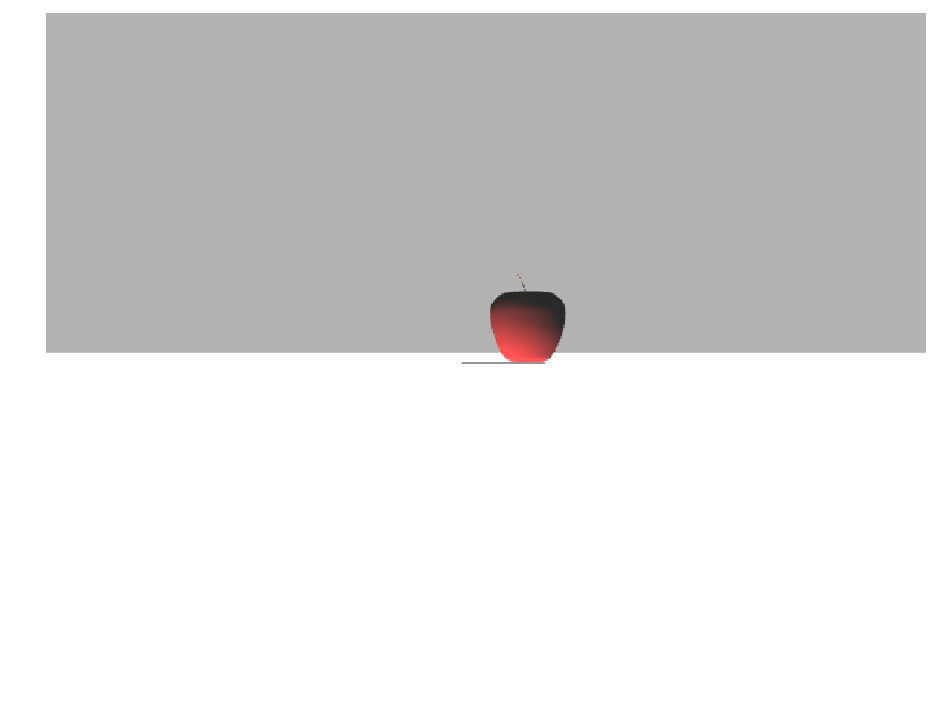

UnboundLocalError: local variable 'padded_mask' referenced before assignment

In [8]:
# this is the latest version
# Load a random image from the images folder

file_names = next(os.walk(IMAGE_DIR))[2]
for img in file_names:
    print("image is: ",img)
    image = skimage.io.imread(os.path.join(IMAGE_DIR, img))
    # Run detection
    results = model.detect([image], verbose=0)
    # Visualize results
    r = results[0]
    print ("displaying result of mrcnn")
    print ("printing rois: ")
#     a = r['rois'][0]
#     y1 = a[0]
#     x1 = a[1]
#     y2 = a[2]
#     x2 = a[3]
#     cx = (x1+x2)/2
#     cy = (y1+y2)/2
    
    print ("cx cy",cx, cy)
    masked_image, padded_mask = display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
    
    number_of_objects = r['masks'].shape[2]
    for i in range(number_of_objects):    
        mask = r['masks'][:, :, i]
        print ("displaying mask")
        plt.imshow(mask)

        contours = find_contours(mask,0.5)
        #print ("disp contours:", contours)
        #contours.sort()
        #print(contours[0][0])
        #print ("min in x ",contours[:,:,0])
        M = moments(mask)
        cx = M[1,0]/M[0,0]
        cy = M[0,1]/M[0,0]
        print ("centroids: ", cx,cy)
        fig, ax = plt.subplots()
        ax.imshow(mask, interpolation='nearest', cmap=plt.cm.gray)

        for n, contour in enumerate(contours):
            print (n)
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
            #print ("iterating: ", contour[:,0].argmax())
            #print ("test: ", contour[0])

        ax.axis('image')
        ax.set_xticks([])
        ax.set_yticks([])
        pc = patches.Circle((cy,cx),15)
        ax.add_patch(pc)
        print ("displaying contour with centroid")
                
        extTop = tuple(contour[contour[:, 0].argmin()])
        extBottom = tuple(contour[contour[:, 0].argmax()])
        extLeft = tuple(contour[contour[:, 1].argmin()])
        extRight = tuple(contour[contour[:, 1].argmax()])
        print ("left: ",extLeft[0],extLeft[1])
        print ("right: ",extRight[0],extRight[1])
        print ("top: ",extTop[0],extTop[1])
        print ("bottom: ",extBottom[0],extBottom[1])
        pc = patches.Circle((extLeft[1],extLeft[0]),10)
        ax.add_patch(pc)
        pc = patches.Circle((extRight[1],extRight[0]),10)
        ax.add_patch(pc)
        pc = patches.Circle((extTop[1],extTop[0]),10)
        ax.add_patch(pc)
        pc = patches.Circle((extBottom[1],extBottom[0]),10)
        ax.add_patch(pc)
        
#         ax.add_patch(pc)
#         circle(image, extLeft, 8, (0, 0, 255), -1)
#         cv2.circle(image, extRight, 8, (0, 255, 0), -1)
#         cv2.circle(image, extTop, 8, (255, 0, 0), -1)
#         cv2.circle(image, extBot, 8, (255, 255, 0), -1)
        plt.show() 
    
    

# this is old version 

import scipy.misc

# Load a random image from the images folder

file_names = next(os.walk(IMAGE_DIR))[2]
for img in file_names:  
    image = skimage.io.imread(os.path.join(IMAGE_DIR, img))
    #image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
    # Run detection
    results = model.detect([image], verbose=0)
        # Visualize results
    r = results[0]
    mask = r['masks'][:, :, 0]
    plt.imshow(mask)
    
    #mat_mask = scipy.misc.toimage(mask)
    #mat_mask = Image.fromarray(mask)
    #_, t2 = cv2.threshold(mask,127,255,0)
    #cv2.imwrite('mat_mask.jpg', mask)
            
    #cnts = cv2.findContours(t2, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    #cnts = imutils.grab_contours(cnts)

    masked_image, padded_mask = display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
    
    contours = find_contours(mask,0.5)
    print(len(contours))
    # loop over the contours
#     for c in contours:
#         # compute the center of the contour
#         M = cv2.moments(c)
#         cX = int(M["m10"] / M["m00"])
#         cY = int(M["m01"] / M["m00"])
#         ctr = np.array(c)#.reshape((-1,1,2)).astype(np.int32)
#         # draw the contour and center of the shape on the image
#         cv2.drawContours(image, ctr, -1, (0, 255, 0), 2)
#         cv2.circle(image, (cX, cY), 7, (255, 255, 255), -1)
#         cv2.putText(image, "center", (cX - 20, cY - 20),
#             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

#         # show the image
#         cv2.imshow("Image", image)
#         cv2.waitKey(0)
    
    #cnts = imutils.grab_contours(contours)
    print ()
    M = moments(padded_mask)
    cx = M[1,0]/M[0,0]
    cy = M[0,1]/M[0,0]
    print ("centroids: ", cx,cy)
    fig, ax = plt.subplots()
    ax.imshow(mask, interpolation='nearest', cmap=plt.cm.gray)
    #print (contours)
    for n, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    pc = patches.Circle((cy,cx),5)
    ax.add_patch(pc)
    #plt.show()
    plt.show() 
    
    #vis.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

import scipy.misc

# Load a random image from the images folder

file_names = next(os.walk(IMAGE_DIR))[2]
#print(file_names)
for img in file_names:  
    image = skimage.io.imread(os.path.join(IMAGE_DIR, img))
    #image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
    # Run detection
    results = model.detect([image], verbose=0)
    #print ("length: ", len(results))
    # Visualize results
    r = results[0]
    print (r['rois'][0])
    print (r['masks'].shape)
    mask = r['masks'][:, :, 0]
    plt.imshow(mask)
    
    #mat_mask = scipy.misc.toimage(mask)
    #mat_mask = Image.fromarray(mask)
    print("type is: ",type(image))
   # _, t2 = cv2.threshold(mask,127,255,0)
    #cv2.imwrite('mat_mask.jpg', mask)
    #print("type is: ",type(mat_mask))
        
    cnts = cv2.findContours(t2, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    masked_image = display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
    print ("dim of masked_img: ", masked_image.shape)
    contours = find_contours(mask,0.5)
    #contours = np.asarray(contours)
    M = moments(mask)
    cx = M[1,0]/M[0,0]
    cy = M[0,1]/M[0,0]
    print ("centroids: ", cx,cy)
    fig, ax = plt.subplots()
    #ax.imshow(mask, interpolation='nearest', cmap=plt.cm.gray)
    print (contours)
    for n, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    pc = patches.Circle((cy,cx),5)
    ax.add_patch(pc)
    #plt.show()
    plt.show()
    
    #vis.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])